<a href="https://colab.research.google.com/github/awest93/comparative_study_of_transformers_and_classic_ML_methods_for_text_classification/blob/main/%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D0%BE%D0%B2_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_ML_%D0%B4%D0%BB%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сравнительный анализ производительности трансформеров и классических методов ML для классификации текста

В работе выполняется сравнительный анализ производительности трансформеров и классических методов ML для классификации текста.

Работа выполняется в следующем порядке:
* загрузка и предварительная обработка набора данных;
* классификация текста классическими методами ML;
* классификация текста с использованием трансформера.
* анализ результатов.

Для классификации текста в работе используются следующие методы ML:
* метод опорных векторов;
* метод k ближайших соседей;
* логистическая регрессия;
* наивный байесовский классификатор;
* метод случайного леса.

Основное преимущество трансформеров заключается в их предобученности на большом количестве разнобразных данных. Трансформер созданный с нуля и обученный на ограниченном наборе данных будет показывать худшие результаты чем готовые предобученные решения. Поэтому, для качественного сравнения производительности с классическими методами ML в качестве трансформера используется distilBERT.

В качестве набора данных для работы используется сборник текстов отмеченных определённой эмоцией. Набор данных доступен по ссылке - https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp.

#1. Подготовительные мероприятия

##1.1 Заргузка и импорт библиотек используемых в работе

In [ ]:
#Установка библиотеки datasets от HuggingFace
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Используется для подсчёта градиента при выводе данных внимания трансформера
import torch

#Используется для подсчёта времени на выполнение операций
import time

#Используется для работы с данными
import numpy as np
import pandas as pd

#Используется для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

#Используется для работы с трансформером
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

#Используется для обработки выборок
from datasets import load_dataset, ClassLabel
from sklearn.feature_extraction.text import TfidfVectorizer

#Используется для упрощения связки векторизатора текста и классификатора
from sklearn.pipeline import Pipeline

#Используется для анализа результатов работы классификаторов и трансформера
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#Классификаторы
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#Вспомогательные библиотеки
import os
import warnings

#Глабальные и системные переменные, а также флаги
os.environ["KAGGLE_KEY"] = "*"
os.environ["KAGGLE_USERNAME"] = "*"
warnings.filterwarnings('ignore')
transformer_name = 'distilbert-base-uncased'

## 1.2 Загрузка набора данных

In [ ]:
#Загрузка и распаковка набора данных
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp
!unzip -qo "emotions-dataset-for-nlp.zip" -d ./dataset

#Загрузка выборок из файлов набора данных
train = load_dataset('csv', data_files = 'dataset/train.txt',
                     sep=';',
                     names=['text', 'label'])['train']
val = load_dataset('csv', data_files = 'dataset/val.txt',
                     sep=';',
                     names=['text', 'label'])['train']
test = load_dataset('csv', data_files = 'dataset/test.txt',
                     sep=';',
                     names=['text', 'label'])['train']

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 110MB/s]


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## 1.3 Анализ набора данных

In [ ]:
#Вывод размера выборок
print(len(train), "Выборка для обучения")
print(len(val), "Выборка для валидации")
print(len(test), "Выборка для тестирования")

16000 Выборка для обучения
2000 Выборка для валидации
2000 Выборка для тестирования


In [ ]:
#Установка формата для создания набора данных в формате pandas
train.set_format(type="pandas")

#Создание набора данных pandas и отображение его первых пяти строк
df = train[:]
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


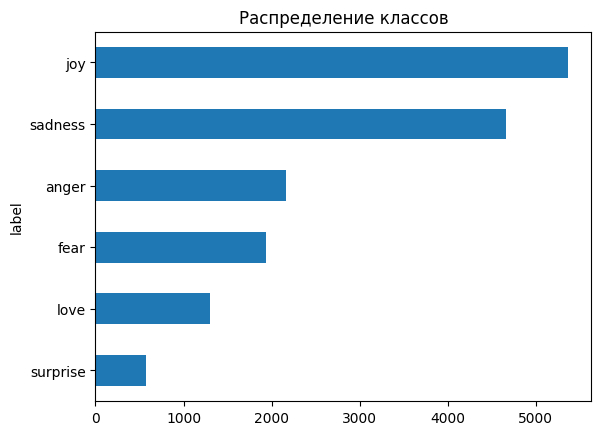

In [ ]:
#Вывод на графике распределения классов
df.label.value_counts(ascending=True).plot.barh()
plt.title('Распределение классов')
plt.show()

Как следует из вывода набор данных несколько несбалансирован, что может негативно повлиять на работу классификаторов и трансформера. Однако, это является возможным сценарием при работе с реальными данными. Поэтому сравнение производительности в условиях неравномерно распределённых классов имеет значение и дополнительные действия для исправления этой ситуации не будут предприниматься.

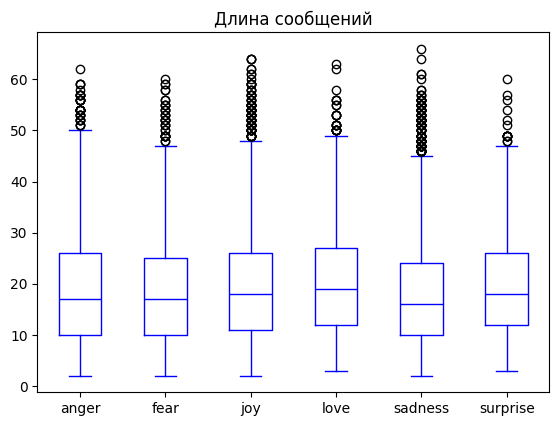

In [ ]:
#Отображение длины сообщений
df['tweets_len'] = df.text.str.split().apply(len)
df.boxplot("tweets_len", by= 'label', grid=False, color='blue')
plt.title('Длина сообщений')
plt.suptitle("")
plt.xlabel("")
plt.show()

Из графика длины сообщений видно что в среднем сообщения имеют примерно одинаковые значения для средней, минимальной и максимальной длины.

## 1.4 Обработка набора данных и создание выборок

Для начала следует заменить метки классов числовым обозначением. Для этого используется инструмент предоставляемый HuggingFace для кодирования меток класса - ClassLabel. Этот инструмент запоминает переданные при инициализации текстовые метки классов, после чего может использоваться для конверсии текстовых меток в закодированные и наоборот.

После создания экземпляра ClassLabel выполняется отображениевсех меток в закодированный формат при помощи вспомогательной функции.

In [ ]:
#Сброс формата к оригинальному формату набора данных HuggingFace
train.reset_format()

#Создание экземпляра ClassLabel
labels = list(df.label.unique())
class_labels = ClassLabel(names=list(labels))

#Вспомогательный метод для кодирования меток класса в выборках
def encode_labels(example):
    example['label'] = class_labels.str2int(example['label'])
    return example

#Выполнение кодирования меток класса в выборках
train = train.map(encode_labels, batched=True)
val = val.map(encode_labels, batched=True)
test = test.map(encode_labels, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Для использования методов машинного обучения нужно создать выборки где данные и их метки будут разделены. Для упрощения процесса существующие выборки переводятся в формат pandas, далее из наборов данных pandas выбоираются текстовые данные и метки классов.

In [ ]:
#Установка формата и создание наборов данных в формате pandas из обучающей и валидационной выборок
val.set_format(type="pandas")
df_val = val[:]
train.set_format(type="pandas")
df = train[:]

#Создание выборок для обучения и тестирования классификаторов ML
ML_X_train = df.text
ML_X_test = df_val.text
ML_y_train = df.label
ML_y_test = df_val.label

#Сброс формата к оригинальному формату набора данных HuggingFace
val.reset_format()
train.reset_format()

Для представления текста в формат используемый трансформером, используется токенизатор связанный с ним.

In [ ]:
#Создание токенизатора связанного с используемым далее трансформером
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

#Вывод параметров токенизатора
print(f"Vocab size -> {tokenizer.vocab_size}\n\
Max input length -> {tokenizer.model_max_length}\n\
Expected Input Column names -> {tokenizer.model_input_names}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocab size -> 30522
Max input length -> 512
Expected Input Column names -> ['input_ids', 'attention_mask']


Как следует из вывода выше токенизатор имеет словарь на 30522 токена и длину токенизированной последовательности в 512 токенов. Это довольно хорошие значения, котрые позволяют охватить широкий диапазон текстовых и символьных обозначений и также кодировать тексты достаточно большой длины.

Далее следует выполнить токенизацию текстов в выборках. Для этого используется отображение из оригинальных выборок со вспомогательной функцией осуществляющей кодирование текста. Также, для удобства, выборкам даны имена указывающее на их назначение в использовании в глубоком обучении.

In [ ]:
#Вспомогательная функция для токенизации текста
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

#Токенизация текста в выборках
DL_train = train.map(tokenize, batched=True, batch_size=None)
DL_val = val.map(tokenize, batched=True, batch_size=None)
DL_test = test.map(tokenize, batched=True, batch_size=None)

#Вывод элемента выборки после токенизации текста
print(DL_train[0])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Как следует из вывода выше токенизация прошла успешно. Элемент выборки содержит данные запрашиваемые на вход моделью (input_ids, attention_mask), а также закодированную метку и оригинальный текст.

#2. Классификация текста классическими методами ML

Как отмечалось во введении для классификации текста далее используются следующие методы ML:
* метод опорных векторов;
* метод k ближайших соседей;
* логистическая регрессия;
* наивный байесовский классификатор;
* метод случайного леса.

В подразделе с каждым методом представлено его краткое описание, обучение, проверка на текстовой выборке и вывод результатов в виде отчёта о классификации и матрицы ошибок.

## 2.1 Метод опорных векторов

Линейные машины опорных векторов (SVM) используются с линейно разделяемыми данными; это означает, что данные не должны подвергаться каким-либо преобразованиям для разделения данных на разные классы. Граница принятия решений и опорные векторы формируют вид улицы, и профессор Патрик Уинстон из Массачусетского технологического института использует аналогию «[подгонки к максимально широкой улице](https://ocw.mit.edu/courses/6-034-artificial-intelligence-fall-2010/resources/mit6_034f10_svm/)» для описания этой квадратичной задачи оптимизации. Под улицей в данной терминологии понимается пространство разделяющее две группы данных и не включающее в себя их. На рисунке ниже приведён пример "улицы", которая размещена между двумя пунктирными линиями.

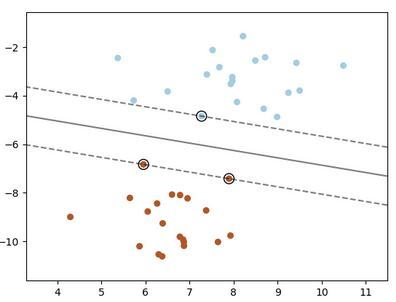

Математически эта разделяющая гиперплоскость может быть представлена ​​как:

wx + b = 0,

где w — вектор веса, x — входной вектор, а b — смещение.

Существует два подхода к вычислению максимального расстояния между классами или предела: классификация с жестким пределом и классификация с мягким пределом. При использовании SVM с жестким пределом, точки данных будут идеально разделены за пределами опорных векторов, или «вне улицы». Это представлено формулой,

(w$x_j$ + b) $y_j$ ≥ a,

и затем предел максимизируется, что представлено как: max ɣ= a / ||w||, где a — это предел, спроецированный на w.


In [ ]:
#Создание конвейера для работы метода, состоящего из двух этапов:
#1. векторизация текста с использованием заданного векторизатора текста;
#2. классификация с использованием заданного классификатора.
pipe_svc = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('SVM', SVC(kernel='linear', random_state=2))
])

#Обучение классификатора в рамках конвейера, с замером времени на обучение
t0 = time.time()
pipe_svc.fit(ML_X_train, ML_y_train)
fit_time_svc = time.time() - t0

#Предсказание классов классификатором в рамках конвейера, с замером времени на предсказание
t0 = time.time()
ML_y_pred = pipe_svc.predict(ML_X_test)
pred_time_svc = time.time() - t0

#Вывод отчёта о классификации
print(classification_report(ML_y_test, ML_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       550
           1       0.91      0.88      0.89       275
           2       0.88      0.75      0.81       178
           3       0.89      0.70      0.79        81
           4       0.82      0.82      0.82       212
           5       0.89      0.94      0.92       704

    accuracy                           0.89      2000
   macro avg       0.88      0.84      0.86      2000
weighted avg       0.89      0.89      0.89      2000



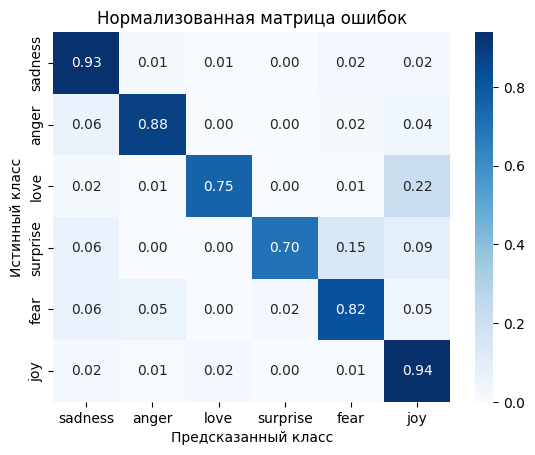

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(ML_y_test, ML_y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

In [ ]:
#Вывод времени на обучение классификатора и предсказание классов
print(f"svc fit time {fit_time_svc:.3f}s ")
print(f"svc predict time {pred_time_svc:.3f}s ")

svc fit time 60.895s 
svc predict time 4.475s 


## 2.2 Метод k ближайших соседей

Принцип, лежащий в основе методов ближайших соседей, заключается в поиске предопределенного количества обучающих образцов, наиболее близких по расстоянию к новой точке, и прогнозировании класса на их основе. Количество образцов может быть константой, определяемой пользователем (обучение по k-ближайшим соседям), или меняться в зависимости от локальной плотности точек (обучение по соседям на основе радиуса). Расстояние, как правило, может быть любой метрической мерой: стандартное евклидово расстояние является наиболее распространенным выбором. Методы, основанные на соседях, известны как необобщающие методы машинного обучения, поскольку они просто «запоминают» все свои обучающие данные.

In [ ]:
#Создание конвейера для работы метода, состоящего из двух этапов:
#1. векторизация текста с использованием заданного векторизатора текста;
#2. классификация с использованием заданного классификатора.
pipe_knn = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('KNN', KNeighborsClassifier())
])

#Обучение классификатора в рамках конвейера, с замером времени на обучение
t0 = time.time()
pipe_knn.fit(ML_X_train, ML_y_train)
fit_time_knn = time.time() - t0

#Предсказание классов классификатором в рамках конвейера, с замером времени на предсказание
t0 = time.time()
ML_y_pred = pipe_knn.predict(ML_X_test)
pred_time_knn = time.time() - t0

#Вывод отчёта о классификации
print(classification_report(ML_y_test, ML_y_pred))

              precision    recall  f1-score   support

           0       0.62      0.84      0.72       550
           1       0.76      0.65      0.70       275
           2       0.68      0.52      0.59       178
           3       0.73      0.54      0.62        81
           4       0.71      0.59      0.65       212
           5       0.79      0.73      0.76       704

    accuracy                           0.71      2000
   macro avg       0.72      0.65      0.67      2000
weighted avg       0.72      0.71      0.71      2000



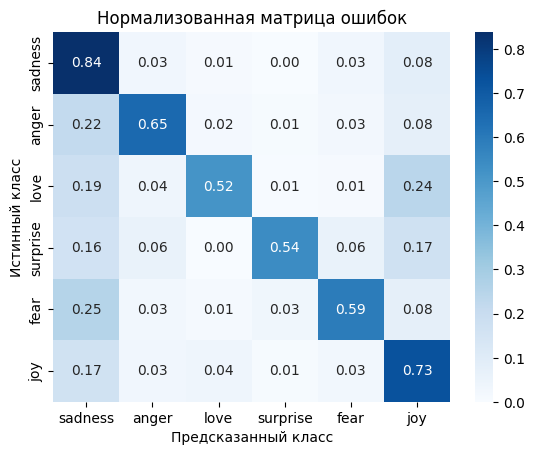

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(ML_y_test, ML_y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

In [ ]:
#Вывод времени на обучение классификатора и предсказание классов
print(f"knn fit time {fit_time_knn:.3f}s ")
print(f"knn predict time {pred_time_knn:.3f}s ")

knn fit time 0.325s 
knn predict time 1.617s 


## 2.3 Логистическая регрессия

Модели линейной регрессии используются для определения взаимосвязи между непрерывной зависимой переменной и одной или несколькими независимыми переменными. Когда есть только одна независимая переменная и одна зависимая переменная, это известно как простая линейная регрессия, но по мере увеличения числа независимых переменных это называется множественной линейной регрессией. Для каждого типа линейной регрессии она стремится построить линию наилучшего соответствия через набор точек данных, который обычно рассчитывается с использованием метода наименьших квадратов.

Подобно линейной регрессии, логистическая регрессия также используется для оценки взаимосвязи между зависимой переменной и одной или несколькими независимыми переменными, но она используется для составления прогноза о категориальной переменной а не непрерывной. Категориальная переменная принимает чёткое значение отображающее категорию, например 1 или 0.

Для многоклассовой классификации используется мультиномиальная логистическая регрессия. В этом типе модели логистической регрессии зависимая переменная имеет три или более возможных результата; однако эти значения не имеют определенного порядка.

In [ ]:
#Создание конвейера для работы метода, состоящего из двух этапов:
#1. векторизация текста с использованием заданного векторизатора текста;
#2. классификация с использованием заданного классификатора.
pipe_lr = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('LR', LogisticRegression(random_state=2))
])

#Обучение классификатора в рамках конвейера, с замером времени на обучение
t0 = time.time()
pipe_lr.fit(ML_X_train, ML_y_train)
fit_time_lr = time.time() - t0

#Предсказание классов классификатором в рамках конвейера, с замером времени на предсказание
t0 = time.time()
ML_y_pred = pipe_lr.predict(ML_X_test)
pred_time_lr = time.time() - t0

#Вывод отчёта о классификации
print(classification_report(ML_y_test, ML_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       550
           1       0.91      0.81      0.86       275
           2       0.88      0.62      0.73       178
           3       0.85      0.58      0.69        81
           4       0.86      0.73      0.79       212
           5       0.84      0.95      0.89       704

    accuracy                           0.86      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.86      0.86      0.85      2000



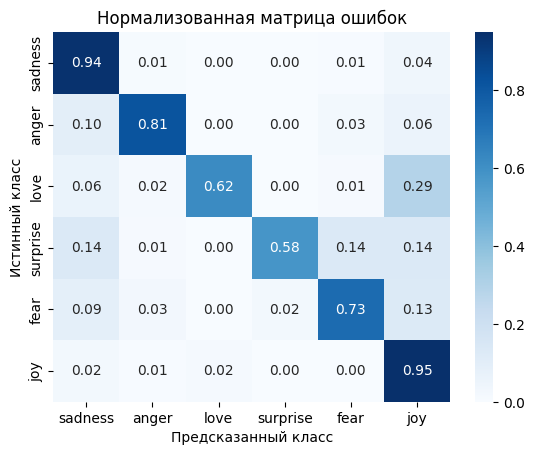

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(ML_y_test, ML_y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

In [ ]:
#Вывод времени на обучение классификатора и предсказание классов
print(f"lr fit time {fit_time_lr:.3f}s ")
print(f"lr predict time {pred_time_lr:.3f}s ")

lr fit time 5.688s 
lr predict time 0.125s 


## 2.4 Наивный байесовский классификатор

Наивный байесовский алгоритм — это вероятностное семейство алгоритмов, основанное на теореме Байеса. Он «наивный», потому что предполагает независимость признаков, что означает, что наличие одного признака не влияет на наличие другого (что может быть не так на практике).

Для многоклассовой классификации используется мультиномиальный наивный байесовский алгоритм. Это вероятностный классификатор для вычисления распределения вероятностей текстовых данных, что делает его хорошо подходящим для данных с признаками, которые представляют дискретные частоты или количество событий в различных задачах обработки естественного языка (NLP).

In [ ]:
#Создание конвейера для работы метода, состоящего из двух этапов:
#1. векторизация текста с использованием заданного векторизатора текста;
#2. классификация с использованием заданного классификатора.
pipe_mnb = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('MNB', MultinomialNB(alpha=.01))
])

#Обучение классификатора в рамках конвейера, с замером времени на обучение
t0 = time.time()
pipe_mnb.fit(ML_X_train, ML_y_train)
fit_time_mnb = time.time() - t0

#Предсказание классов классификатором в рамках конвейера, с замером времени на предсказание
t0 = time.time()
ML_y_pred = pipe_mnb.predict(ML_X_test)
pred_time_mnb = time.time() - t0

#Вывод отчёта о классификации
print(classification_report(ML_y_test, ML_y_pred))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       550
           1       0.77      0.59      0.67       275
           2       0.88      0.39      0.54       178
           3       0.87      0.25      0.38        81
           4       0.67      0.58      0.62       212
           5       0.73      0.86      0.79       704

    accuracy                           0.72      2000
   macro avg       0.76      0.58      0.62      2000
weighted avg       0.73      0.72      0.70      2000



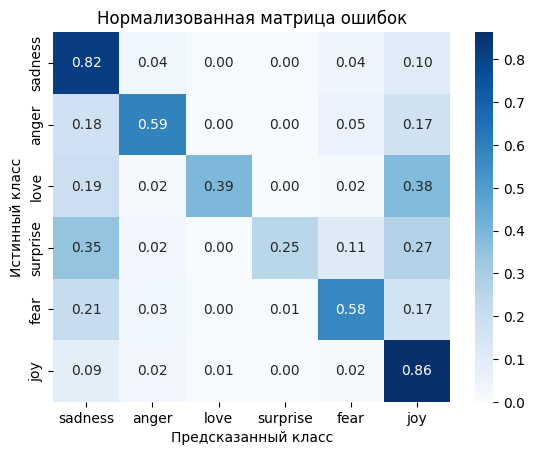

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(ML_y_test, ML_y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

In [ ]:
#Вывод времени на обучение классификатора и предсказание классов
print(f"mnb fit time {fit_time_mnb:.3f}s ")
print(f"mnb predict time {pred_time_mnb:.3f}s ")

mnb fit time 0.651s 
mnb predict time 0.072s 


## 2.5 Метод случайного леса

Алгоритм случайного леса состоит из набора деревьев решений, и каждое дерево в ансамбле состоит из выборки данных, взятой из обучающего набора с заменой, называемой начальной(bootstrap) выборкой. Из этой обучающей выборки одна треть откладывается в качестве тестовых данных, известных как выборка из вне (out-of-bag sample, OOB), к которой мы вернемся позже. Ещё один элемент случайности вводится посредством пакетирования признаков, добавляя больше разнообразия в набор данных и уменьшая корреляцию между деревьями решений. В зависимости от типа проблемы определение прогноза будет различаться. Для задачи регрессии отдельные деревья решений будут усреднены, а для задачи классификации большинство голосов, т. е. наиболее частая категориальная переменная, даст предсказанный класс. Наконец, выборка OOB используется для перекрестной проверки, завершая этот прогноз.

In [ ]:
#Создание конвейера для работы метода, состоящего из двух этапов:
#1. векторизация текста с использованием заданного векторизатора текста;
#2. классификация с использованием заданного классификатора.
pipe_rf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('RF', RandomForestClassifier(random_state=2))
])

#Обучение классификатора в рамках конвейера, с замером времени на обучение
t0 = time.time()
pipe_rf.fit(ML_X_train, ML_y_train)
fit_time_rf = time.time() - t0

#Предсказание классов классификатором в рамках конвейера, с замером времени на предсказание
t0 = time.time()
ML_y_pred = pipe_rf.predict(ML_X_test)
pred_time_rf = time.time() - t0

#Вывод отчёта о классификации
print(classification_report(ML_y_test, ML_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       550
           1       0.90      0.83      0.86       275
           2       0.88      0.72      0.79       178
           3       0.88      0.70      0.78        81
           4       0.85      0.78      0.82       212
           5       0.84      0.94      0.89       704

    accuracy                           0.87      2000
   macro avg       0.88      0.82      0.84      2000
weighted avg       0.87      0.87      0.87      2000



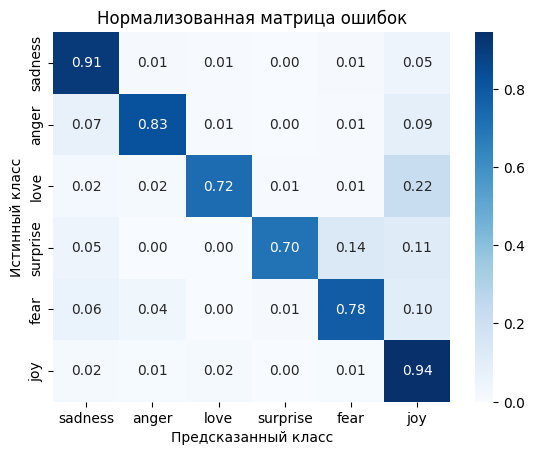

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(ML_y_test, ML_y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

In [ ]:
#Вывод времени на обучение классификатора и предсказание классов
print(f"random forest fit time {fit_time_rf:.3f}s ")
print(f"random forest predict time {pred_time_rf:.3f}s ")

random forest fit time 34.740s 
random forest predict time 0.229s 


#3. Классификация текста трансформером

Модель distilBERT, используемая в данной работе, является уменьшенной версией модели BERT. По данным, представленным в [статье](https://arxiv.org/pdf/1910.01108) описывающей distilBERT, она сохраняет до 97% производительности BERT, при этом уменьшая размер модели примерно на 40% и обеспечивает повышение скорости работы до 60%.

Модель BERT, по заявлению разработчиков из [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805), имеет архитектуру многослойного двунаправленного кодировщика трансформера основанного на реализации описанной в статье [Attention is All You Need](https://arxiv.org/pdf/1706.03762).

Таким образом, используемая модель, имеет архитектуру кодировщика, из трансформера представленого в статье [Attention is All You Need](https://arxiv.org/pdf/1706.03762) в 2017 году.

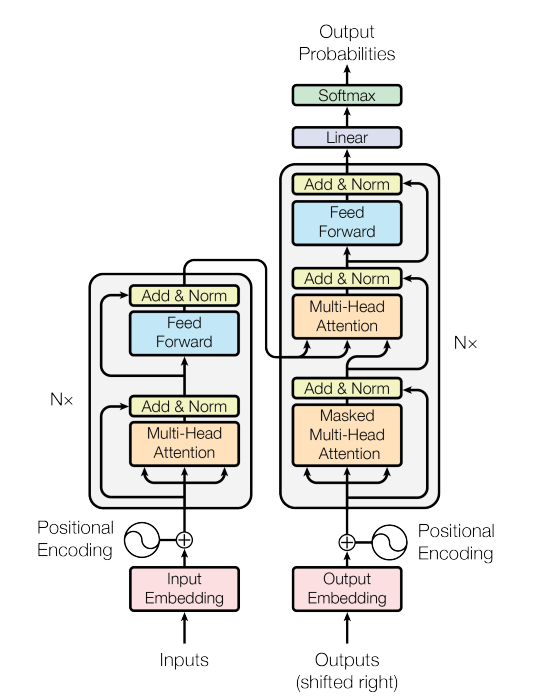

На рисунке выше представленна оригинальная архитектура трансформера. Она состоит из двух частей: кодировщика (слева) и декодировщика (справа). Кодировщик занимается извлечением принзаков входного текста, а декодировщик выполняет генерацию выходного текста.

Модель distilBERT использует только слои кодировщика, что позволяет адаптировать её под разные задачи. Она извлекает из входного текста признаки, которые можно будет использовать на выходных слоях. Таким образом итоговая архитектура модели принимает вид отображённый на рисунке ниже.

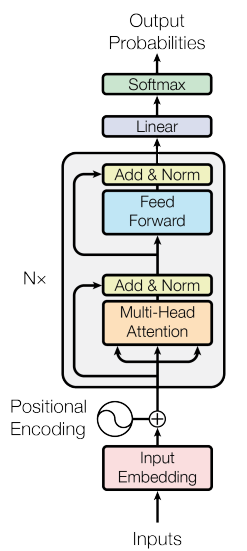

Работа с трансформаром осуществляется в следующем порядке:
* Вывод данных внимания до дообучения модели;
* Дообучение модели;
* Анализ результатов обучения;
* Вывод данных внимания после обучения модели.

## 3.1 Вывод данных внимания до дообучения

Для начала следует провести визуализацию усреднённых градиентов для каждого слова. Это позволит понять какие части предложения модель считает важными, а какие нет.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


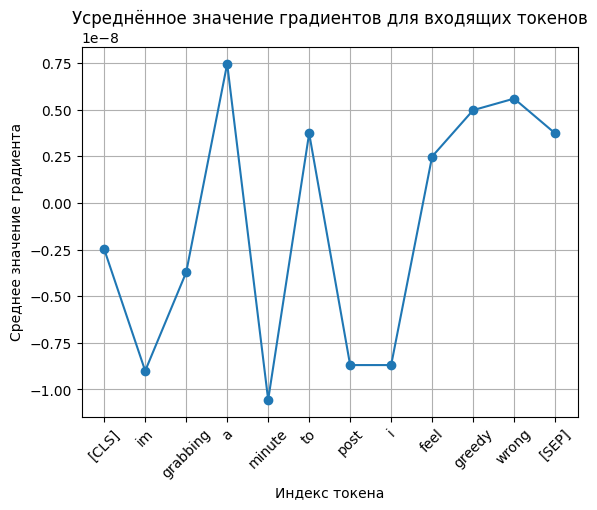

In [ ]:
#Загрузка модели трансформера на присутствующее в системе устройство (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(transformer_name,
                                                           num_labels=len(labels),
                                                           output_attentions=True,
                                                           output_hidden_states=True).to(device)

#токенизация текста из обучающей выборки
inputs = tokenizer(DL_train[2]['text'], return_tensors="pt")

#Получение эмбеддингов для токенизированного текста
embeddings = model.distilbert.embeddings.word_embeddings(inputs['input_ids'].cuda())

#Вычисление градиентов на основании эмбеддингов и последнего скрытого состояния модели
embeddings.retain_grad()
outputs = model(inputs_embeds=embeddings)
loss = outputs.hidden_states[-1].sum()
loss.backward()
gradients = embeddings.grad

#Усреднение градиентов
average_gradients = gradients[0].mean(dim=1).cpu().detach().numpy()

#Вывод усреднённых градиентов
plt.plot(average_gradients, marker='o')
plt.title("Усреднённое значение градиентов для входящих токенов")
plt.xlabel("Индекс токена")
plt.ylabel("Среднее значение градиента")
plt.xticks(ticks=range(len(average_gradients)), labels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), rotation=45)
plt.grid(True)
plt.show()

Как следует из вывода выше, модель считает наиболее важными слова im, a, to, feel, greedy, wrong. Если одно из этих слов заменить, это приведёт к изменению вывода модели. Также стоит отметить что модель пока не дообучена, поэтому значения слов она берёт из своего прошлого опыта и это может не совпадать с требованиями текущей задачи.

Далее следует провести визуализацию весов внимания по всем головам внимания модели. Это позволит оценить видение моделью связей между словами предложения, а также, за счёт большого количества голов внимания, увидеть разные вариации этих связей.

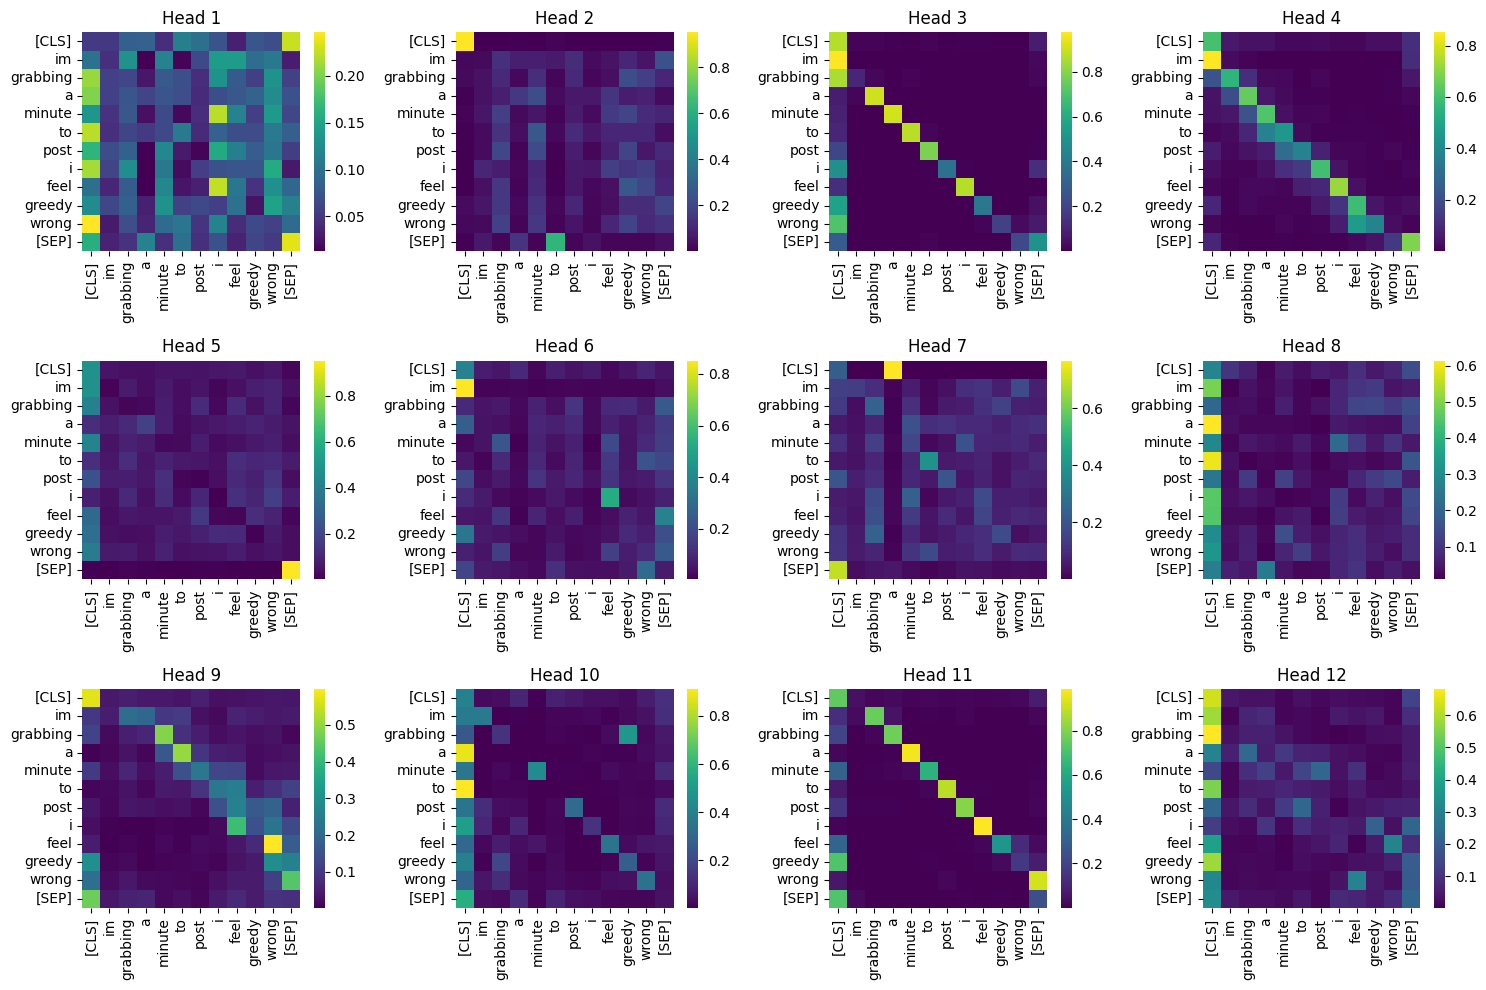

In [ ]:
#Получение данных с голов внимания модели
attention = outputs.attentions

#Построение графиков весов внимания для всех голов внимания модели
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    sns.heatmap(attention[0][0][i].detach().cpu().numpy(), ax=ax, cmap="viridis",
                xticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
                yticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
    ax.set_title(f"Head {i+1}")
plt.tight_layout()
plt.show()

Из вывода голов внимания следует что некоторые головы внимания считают что пары слов grabbing-minute, to-post, i-feel, a-minute, feel-i, feel-wrong имеют между собой некоторую связь, и в принципе действительно определённая связь в приведённых парах есть.

## 3.2 Дообучение модели

In [ ]:
#Удаление вывода ненужных в ходе обучения параметров, из-за которых ресурсоёмкость процесса значительно возрастёт.
#А в среде google colab станет вовсе невозможной из-за черезмерного потребления памяти на хранение большого количества крупных тензоров.
model.config.output_attentions = False
model.config.output_hidden_states = False

#Определение функции возвращающей значения метрик
def compute_metrics(preds):
    labels = preds.label_ids
    pred = preds.predictions.argmax(-1)
    f1 = f1_score(labels, pred, average='weighted')
    acc = accuracy_score(labels, pred)
    return {'accuracy': acc, 'f1-score': f1}

#Задание параметров обучения
batch_size = 64
model_name = f"{transformer_name}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                num_train_epochs=5,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                eval_strategy="epoch",
                                push_to_hub=False,
                                report_to="none")

#Создание класса тренера для обучения модели
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=DL_train,
                  eval_dataset=DL_val)

#Запуск обучения и подсчёта времени на него
t0 = time.time()
trainer.train()
fit_time_transformer = time.time() - t0

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,No log,0.279417,0.915000,0.915081
2,0.506500,0.184811,0.927500,0.927515
3,0.506500,0.156006,0.931500,0.932405
4,0.121500,0.149768,0.937500,0.937211
5,0.121500,0.147925,0.934000,0.934044


## 3.3 Анализ результатов обучения

Для начала выполняется визуализация процесса обучения, в частности точность и потеря на валидационной выборке.

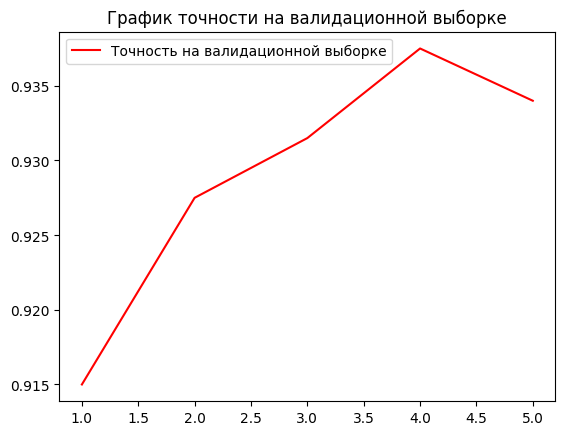

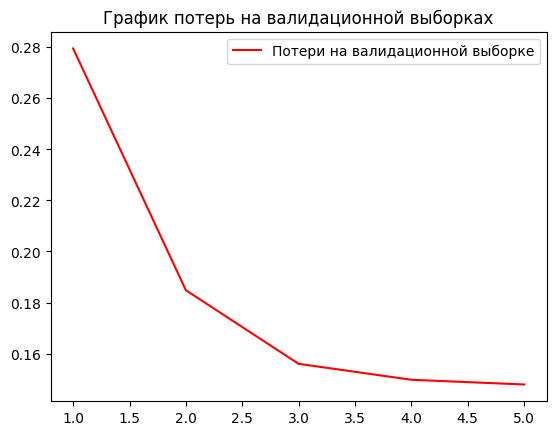

In [ ]:
#Сбор данных о процессе обучения
acc = []
loss = []
epochs = []
for el in trainer.state.log_history:
    if('eval_accuracy' in el):
        acc.append(el['eval_accuracy'])
        loss.append(el['eval_loss'])
        epochs.append(el['epoch'])

#Визуализация данных о процессе обучения
plt.plot(epochs, acc, 'r', label='Точность на валидационной выборке')
plt.title('График точности на валидационной выборке')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Потери на валидационной выборке')
plt.title('График потерь на валидационной выборках')
plt.legend()
plt.show()

Как следует из графиков модель на последних эпохах обучение модели сильно замедлилось, однако не остановилось. В принципе можно было бы понизить скорость обучения и продолжать процесс, но даже сейчас, полученная точность выглядит весьма неплохо, поэтому продолжение обучения не осуществляется.

Далее следует выполнить предсказание классов из тестовой выборки и вывести время затраченное на обучение и предсказание классов для трансформера, а также отчёт о классификации.

In [ ]:
#Предсказание классов на тестовой выборке с замером времени на предсказание
t0 = time.time()
test_preds_output = trainer.predict(DL_test)
pred_time_transformer = time.time() - t0

#Вывод времени на обучение трансформера и на предсказание классов
print(f"transformer fit time {fit_time_transformer:.3f}s ")
print(f"transformer predict time {pred_time_transformer:.3f}s ")

#Обработка предсказаний трансформера и вывод отчёта о классификации
y_preds = np.argmax(test_preds_output.predictions, axis=1)
print(classification_report(DL_test['label'], y_preds))

transformer fit time 601.627s 
transformer predict time 3.578s 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           1       0.93      0.92      0.92       275
           2       0.78      0.89      0.83       159
           3       0.88      0.68      0.77        66
           4       0.87      0.93      0.90       224
           5       0.96      0.94      0.95       695

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



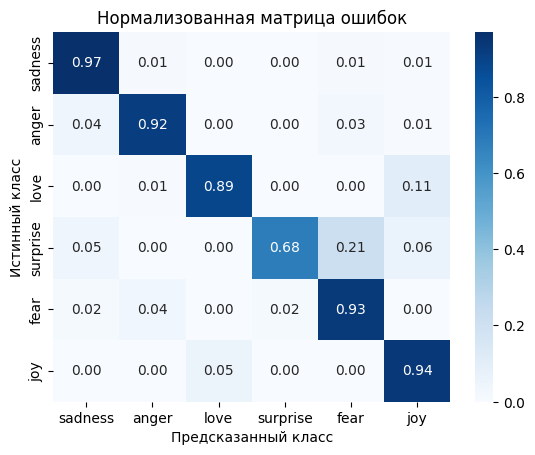

In [ ]:
#Вывод нормализованной матрицы ошибок
cm = confusion_matrix(DL_test['label'], y_preds, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()

## 3.4 Вывод данных внимания после обучения

После проведения обучения следует оценить изменения в восприятии моделью ранее проверенной фразы.

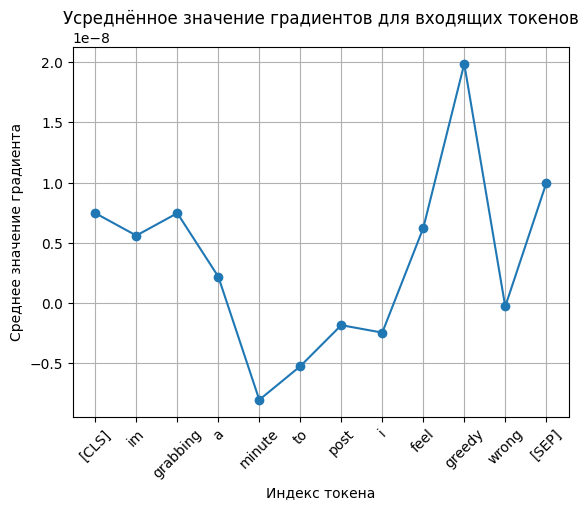

In [ ]:
#Установка вывода скрытых состояний и весов голов внимания.
model.config.output_attentions = True
model.config.output_hidden_states = True

#токенизация текста из обучающей выборки
inputs = tokenizer(DL_train[2]['text'], return_tensors="pt")

#Получение эмбеддингов для токенизированного текста
embeddings = model.distilbert.embeddings.word_embeddings(inputs['input_ids'].cuda())

#Вычисление градиентов на основании эмбеддингов и последнего скрытого состояния модели
embeddings.retain_grad()
outputs = model(inputs_embeds=embeddings)
loss = outputs.hidden_states[-1].sum()
loss.backward()
gradients = embeddings.grad

#Усреднение градиентов
average_gradients = gradients[0].mean(dim=1).cpu().detach().numpy()

#Вывод усреднённых градиентов
plt.plot(average_gradients, marker='o')
plt.title("Усреднённое значение градиентов для входящих токенов")
plt.xlabel("Индекс токена")
plt.ylabel("Среднее значение градиента")
plt.xticks(ticks=range(len(average_gradients)), labels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), rotation=45)
plt.grid(True)
plt.show()

Как можно заметить значимость слов в предложении несколько изменилась по сравнению с оценкой до обучения. Так, например, слово greedy получило значительное увеличениеважности по сравнению с остальными, и в принципе с учётом класса этого сообщения (anger) это выглядит вполне логично.

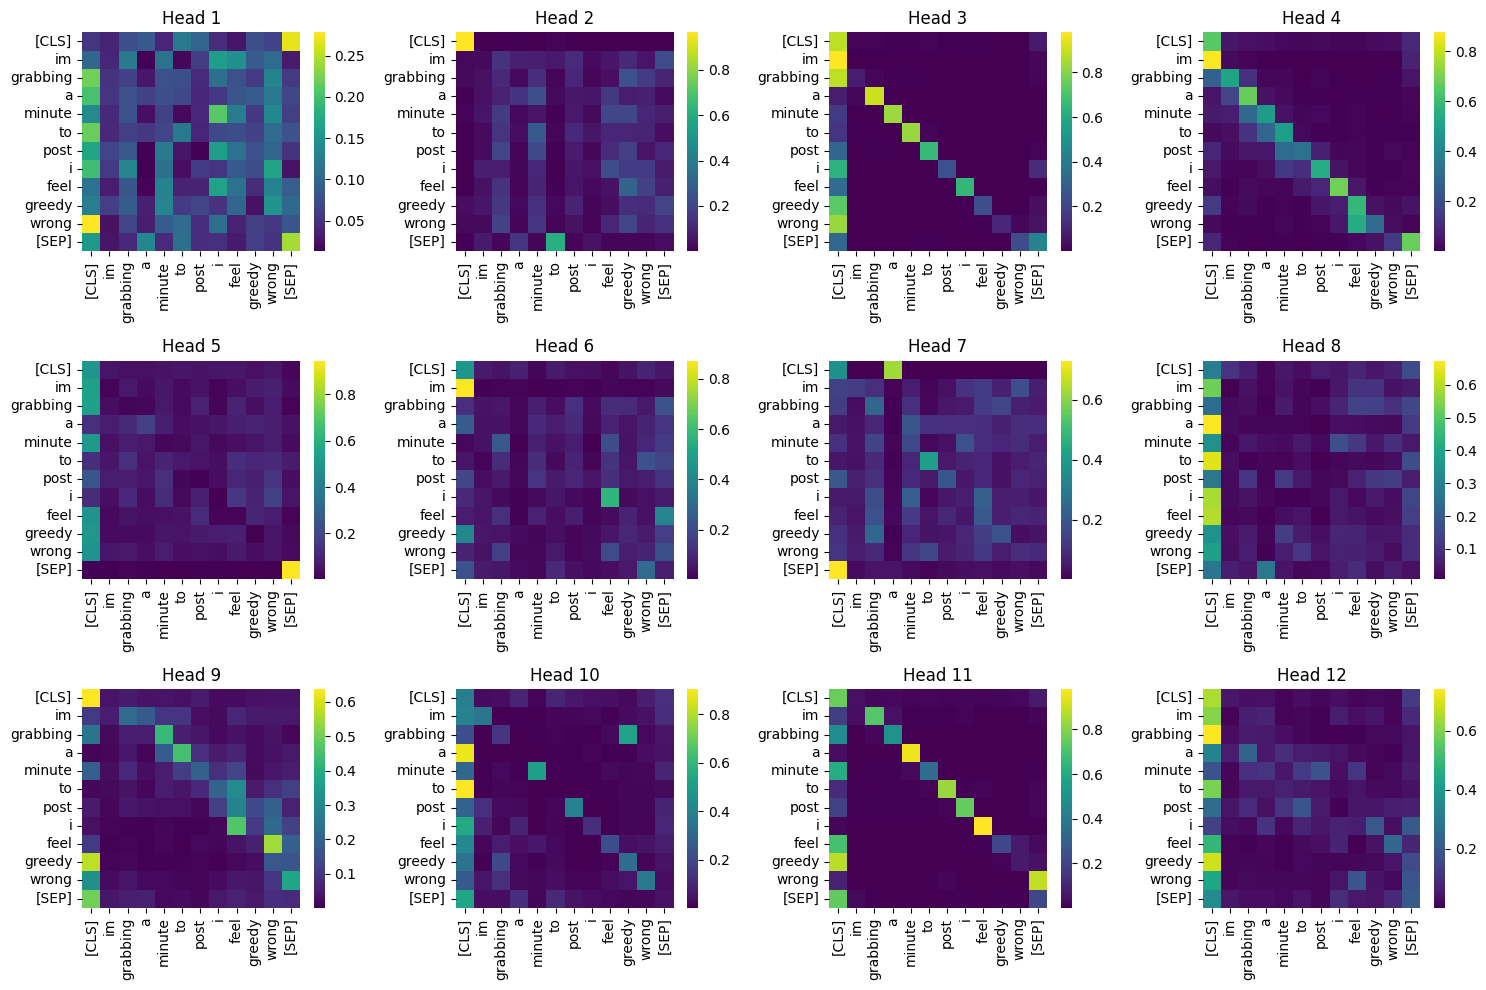

In [ ]:
#Получение данных с голов внимания модели
attention = outputs.attentions

#Построение графиков весов внимания для всех голов внимания модели
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    sns.heatmap(attention[0][0][i].detach().cpu().numpy(), ax=ax, cmap="viridis",
                xticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
                yticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
    ax.set_title(f"Head {i+1}")
plt.tight_layout()
plt.show()

В весах голов внимания значимых изменений не произошло, хотя заметно что некоторые пары слов утратили часть старого значения. Возможно, при более длительном обучении веса голов вннимания перестроились бы сильнее.

#4. Заключение

Для начала следует кратко повторить данные полученные в ходе работы.

Метод опорных векторов:
* наименьшее количество верных ответов: surprise, 70%
* наибольшее количество верных ответов: joy, 94%
* средняя точность: 89%
* время обучения: 60.895s
* время предсказания: 4.475s

Метод k ближайших соседей:
* наименьшее количество верных ответов: love, 52%
* наибольшее количество верных ответов: sadness, 84%
* средняя точность: 71%
* время обучения: 0.325s
* время предсказания: 1.617s

Логистическая регрессия:
* наименьшее количество верных ответов: surprise, 58%
* наибольшее количество верных ответов: joy, 95%
* средняя точность: 86%
* время обучения: 5.688s
* время предсказания: 0.125s

Наивный байесовский классификатор:
* наименьшее количество верных ответов: surprise, 25%
* наибольшее количество верных ответов: joy, 86%
* средняя точность: 72%
* время обучения: 0.651s
* время предсказания: 0.072s

Метод случайного леса:
* наименьшее количество верных ответов: surprise, 70%
* наибольшее количество верных ответов: joy, 94%
* средняя точность: 87%
* время обучения: 34.740s
* время предсказания: 0.229s

Трансформер:
* наименьшее количество верных ответов: surprise, 68%
* наибольшее количество верных ответов: sadness, 97%
* средняя точность: 93%
* время обучения: 601.627s
* время предсказания: 3.578s

Методы ML продемонстрировали хороший результат в большинстве случаев. Они потребляют мало ресурсов, быстро обучаются и выдают предсказания. Также стоит отметить что несбалансированность набора данных оказала негативное влияние на результаты моделей ML. Так по всем классам которые были слабо представлены в наборе точность методов ML значительно ниже чем по остальным классам.

Трансформер демонстрирует лучшую среднюю точность по сравнению с рассмотренными методами ML, при этом точность в теории можно улучшить на 1-2 процента при более длительном обучении. Несбалансированность набора данных не оказала сильного влияние на результаты трансформера. Это связано с тем, что он изучает взаимосвязи между элементами текста в отличии от методов ML, и потому ему требуется меньше данных для качественной работы, хотя самый недопредставленный класс всё равно получил достаточно низкую точность даже у трансформера.

По потреблению ресурсов трансформер значительно уступает рассмотреным методам ML. Во-первых трансформеру потребовался видеоускоритель для адекватных сроков обучения, без GPU он бы обучался примерно 10 часов. Во-вторых при обучении для трансформера было выделено 3,5 Гб видеопамяти и примерно 1,5 Гб оперативной памяти. В то время как расход ОЗУ у классических методов ML не был заметен в мониторе ресурсов google colab. Стоит отметить что во время предсказания трансформер потребляет значительно меньше ресурсов и даже не требует GPU для приемлемой скорости работы, а по скорости предсказаний превосходит самый медленный из рассмотренных алгоритмов ML, что делает его в значительной степени сопоставимым с рассмотренными методами ML.

В целом, в условиях несбалансированности данных, трансформер является хорошей альтернативой для классических методов ML, если имеется возможность проведения его дообучения под нужную задачу.